In [116]:
import numpy as np
from numpy.linalg import eigvals
import matplotlib.pyplot as plt

Recall the complex finite-dimensional case:

Analysis operator maps a vector $f\in \mathbb{C}^n$ to its frame coefficients via inner products with the $(f_i)_{i\in I}\subset \mathbb{C}^n$.
$\begin{align}
    T^*:\mathbb{C}^n &\rightarrow \mathbb{C}^m \\ f&\mapsto\left(\langle f, f_i\rangle\right)_{i\in I} = \left(\overline{\langle f_i, f\rangle}\right)_{i\in I}
\end{align}$
Matrix multiplication from the left:
$$T^* f = \begin{pmatrix}
    -\quad  \overline{f_1}\quad  -\\
  
    -\quad  \overline{f_2}\quad  -\\
      \vdots  \\
    -\quad  \overline{f_m}\quad  -
\end{pmatrix} f$$

Discrete finite Gabor frames.

Signal $f\in \mathbb{C}^L$ is mapped to a set of Gabor frame coefficients $c\in \mathbb{C}^{M\times N}$ using time-shifts and modulations of a window $g\in \mathbb{C}^L$.

Time-shift by $\tau:\qquad\;\;$     $(T_{na} g)(\ell) = g((\ell - \tau) \mod L)$ 

Modulation by $\omega:\qquad$    $(E_{mb} g)(\ell) = g(\ell)e^{2\pi i \ell \omega / L}$

$a$ ... time hop-size

$b$ ... frequency hop-size

A Gabor atom is a time-shifted and modulated version of $g$ by multiples of $a,b$:
$$g_{m,n}(\ell) = (E_{mb}T_{na}g)(\ell) = g(\ell-an)e^{2\pi i \ell m b / L}$$
A Gabor frame coefficient:

$$c(m,n) = \langle f,g_{m,n} \rangle = \sum_{\ell=0}^{L-1}f(\ell)\overline{g}(\ell-an)e^{-2\pi i \ell m b / L} $$

$$c_{vec} = \begin{pmatrix}
    -\quad  \overline{g_{0,0}}\quad  -\\
  
    -\quad  \overline{g_{1,0}}\quad  -\\
      \vdots  \\
    -\quad  \overline{g_{M-1,0}}\quad  -\\
    -\quad  \overline{g_{0,1}}\quad  -\\
  
    -\quad  \overline{g_{1,1}}\quad  -\\
      \vdots  \\
    -\quad  \overline{g_{M-1,1}}\quad  -\\
      \vdots  \\
    -\quad  \overline{g_{0,N-1}}\quad  -\\
  
    -\quad  \overline{g_{1,N-1}}\quad  -\\
      \vdots  \\
    -\quad  \overline{g_{M-1,N-1}}\quad  -\\
\end{pmatrix} f$$

$\rightarrow M = L/a, N = L/b\qquad$ CAUTION: divisibility!

Frame condition $ab<1$ (with a Gaussian) translates to $MN\geq L \Leftrightarrow ab\leq L$

In [117]:
# load a speech signal
import librosa
speech_full = librosa.load('signals/speech.wav')
speech_full = librosa.resample(speech_full[0],orig_sr=22050,target_sr=8000)
speech = speech_full[:8000]
speech= speech/np.linalg.norm(speech)

In [118]:
from IPython.display import Audio
Audio(data=speech, rate=8000)

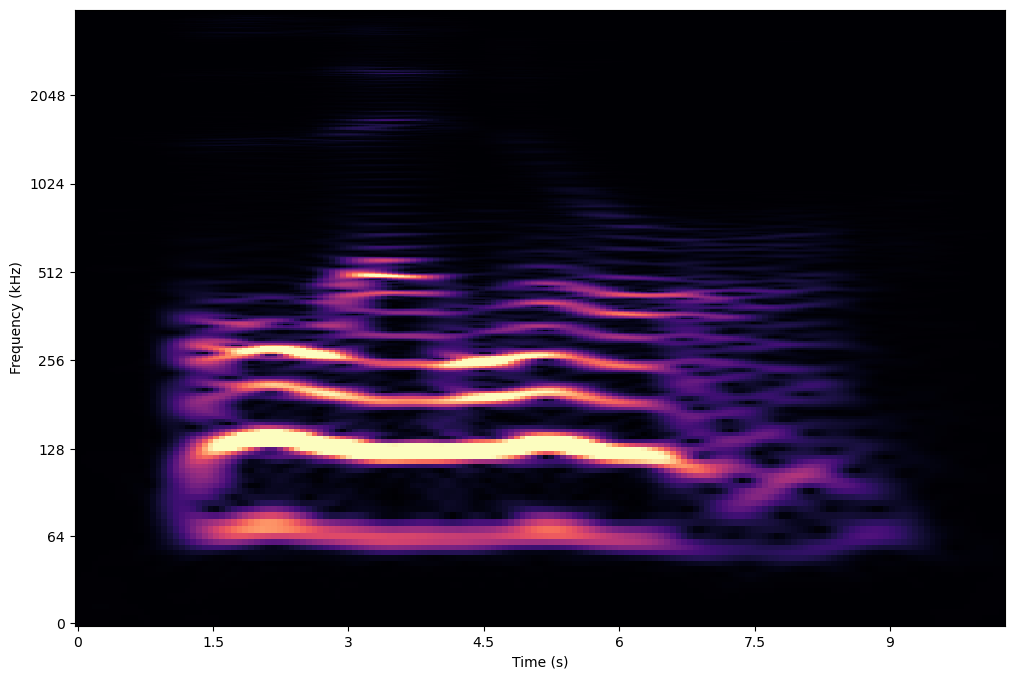

In [119]:
# STFT from librosa
plt.figure(figsize=(12,8))
D = np.abs(librosa.stft(speech, n_fft=2000, hop_length=50, win_length=1000))
img = librosa.display.specshow(D, y_axis='log', x_axis='time', sr=8000, vmin=0, vmax=2)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.show()

Let's do it the frame way!

Disclaimer: This will be computationally very inefficient and not how it's done in practice!

In [120]:
# Gaussian window of lenght L and width sigma
def gauss(L, sigma):
    g = np.exp(-np.pi * np.arange(-L//2,L//2)**2 / (sigma/2)**2)
    return np.roll(g, L//2) # make it center symmetric

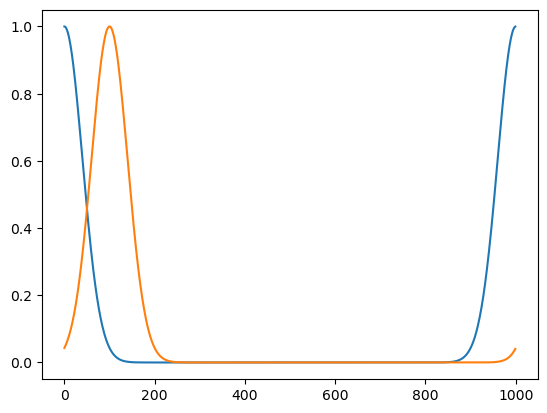

In [121]:
g = gauss(1000,200)

plt.plot(g)
plt.plot(np.roll(g,100))
plt.show()

In [122]:
# translation operator
def T(g,a):
    return np.roll(g, a)

# modulation operator
def E(g,b):
    L = len(g)
    return np.exp(2 * np.pi * 1j * b * np.arange(L) / L) * g

# Gabor atom
def gabor_atom(g,a,b):
    return E(T(g,a),b)

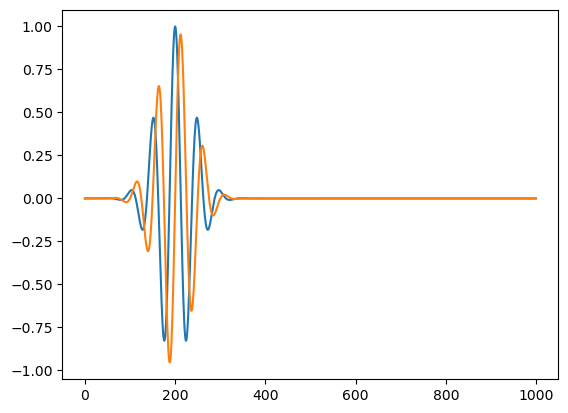

In [123]:
# example
a = 10
b = 10
g_mn = gabor_atom(g,20*a,2*b)
plt.plot(np.real(g_mn))
plt.plot(np.imag(g_mn))
plt.show()

In [124]:
# Gabor analysis operator
def Gab(g,a,b):
    L = len(g)
    N = L//a
    M = L//b
    Ana = np.zeros((M*N,L), dtype=complex)
    idx = 0
    for n in range(N):
        for m in range(-M//2,M//2):
            Ana[idx,:] = gabor_atom(g,n*a,m*b).conj()
            idx += 1
    return Ana

In [125]:
Ana = Gab(g,10,10)
Ana.shape

(10000, 1000)

In [126]:
# Gram matrix
G = Ana @ Ana.conj().T

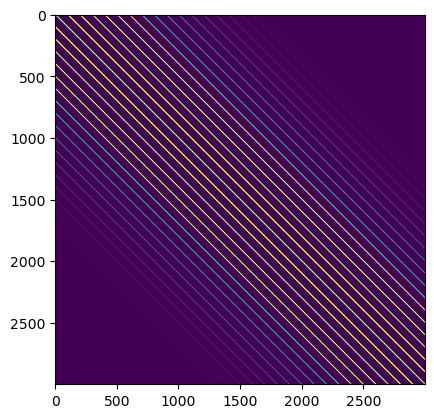

In [127]:
# shows localization - decay from the main diagonal
plt.imshow(np.abs(G[:3000,:3000]), vmin=0, vmax=5)
plt.show()

In [128]:
# frame operator
S = Ana.conj().T @ Ana

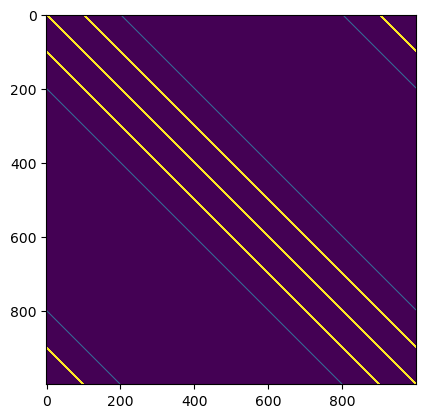

In [129]:
# has nice structure
plt.imshow(np.abs(S), vmin=0, vmax=1)
plt.show()

In [134]:
# frame bounds
lams = eigvals(S)
A = np.min(lams)
B = np.max(lams)
print('A =', np.real(A),'\n','B =', np.real(B),'\n','conditon number =', np.real(B/A))


A = 415.76060259601866 
 B = 1003.7348854878203 
 conditon number = 2.4142135623733387


Gabor analysis of the speech signal from the beginning

In [173]:
# signal length
L = speech.shape[0]

# window
g = gauss(L,500)

# time-hop size
# a = 100
a = 80

# frequency-hop size
# b = 40
b = 20

# number of coefficients in time
N = L//a

# number of coefficients in frequency
M = L//b

# size of the analysis operator
print('number of coefficients in time:', N)
print('number of coefficients in frequency:', M)
print('size of the analysis operator:', M*N,L)
print('shape of the Gabor coefficients:', M,N)
print('redundancy:', M*N/L)

number of coefficients in time: 100
number of coefficients in frequency: 400
size of the analysis operator: 40000 8000
shape of the Gabor coefficients: 400 100
redundancy: 5.0


In [174]:
# Gabor analysis operator
Ana = Gab(g,a,b)
Ana.shape

(40000, 8000)

In [175]:
# Apply it to the signal -> Gabor coefficients
c_vec = Ana @ speech
c_vec.shape

(40000,)

In [176]:
# reshape to the correct format
c = np.reshape(c_vec,(N,M)).T
c.shape

(400, 100)

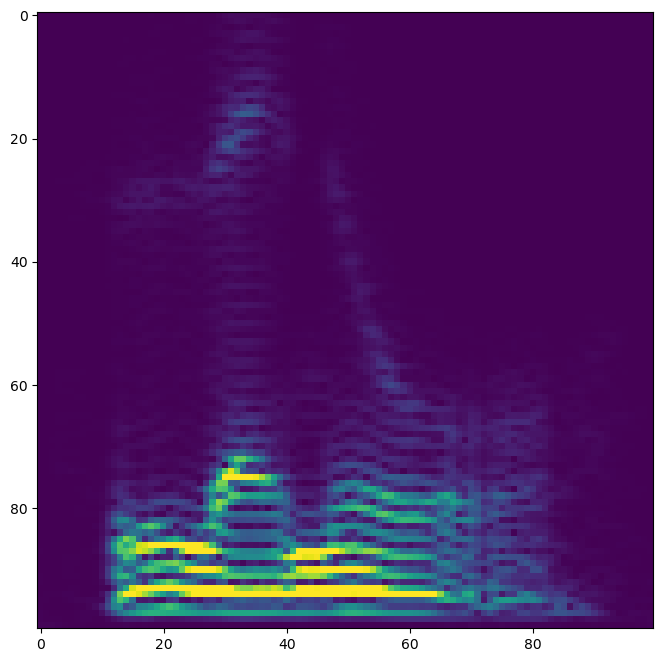

In [178]:
# plot the coefficients as image (only positive frequencies)
plt.figure(figsize=(12,8))
plt.imshow(np.abs(c[100:M//2,:]), vmin=0, vmax=1)
plt.show()

a lot more redundancy is needed to make that look nice...

In [157]:
# plot localization of a Gabor atom in time and frequency
g = gauss(L,150)
c_vec_loc_1 = Ana @ gabor_atom(g,4000,2000)
c_loc_1 = np.flipud(np.reshape(c_vec_loc_1,(N,M)).T)
c_vec_loc_2 = Ana @ gabor_atom(g,2000,3000)
c_loc_2 = np.flipud(np.reshape(c_vec_loc_2,(N,M)).T)

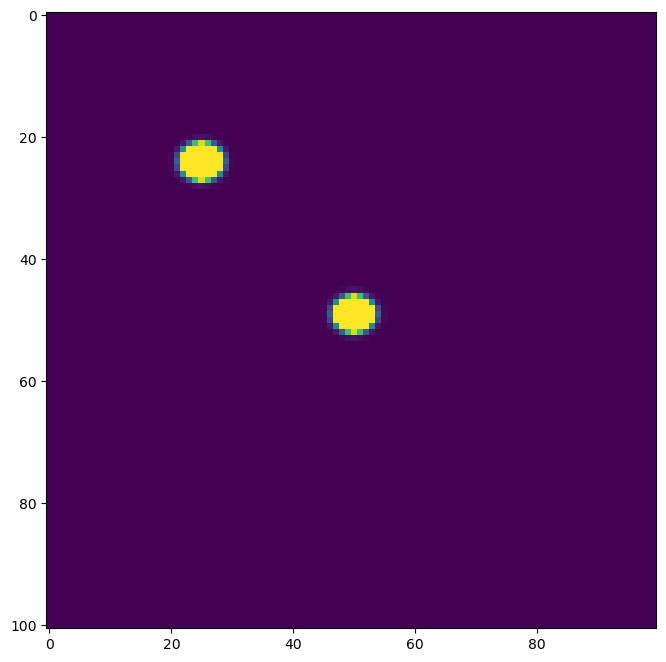

In [159]:
plt.figure(figsize=(12,8))
plt.imshow(np.abs(c_loc_1[:M//2+1,:])+np.abs(c_loc_2[:M//2+1,:]), vmin=0, vmax=2)
plt.show()

In [160]:
# other examples

# snare

L = 8000

drums_full = librosa.load('signals/snare.wav')
drums_full = librosa.resample(drums_full[0],orig_sr=22050,target_sr=8000)
drums = drums_full[:L]
drums = drums/np.linalg.norm(drums)

# flute

flute_full = librosa.load('signals/flute.wav')
flute_full = librosa.resample(flute_full[0],orig_sr=22050,target_sr=8000)
flute = flute_full[:L]
flute = flute/np.linalg.norm(flute)

In [161]:
c_vec_flute = Ana @ flute
c_flute = np.reshape(c_vec_flute,(N,M)).T

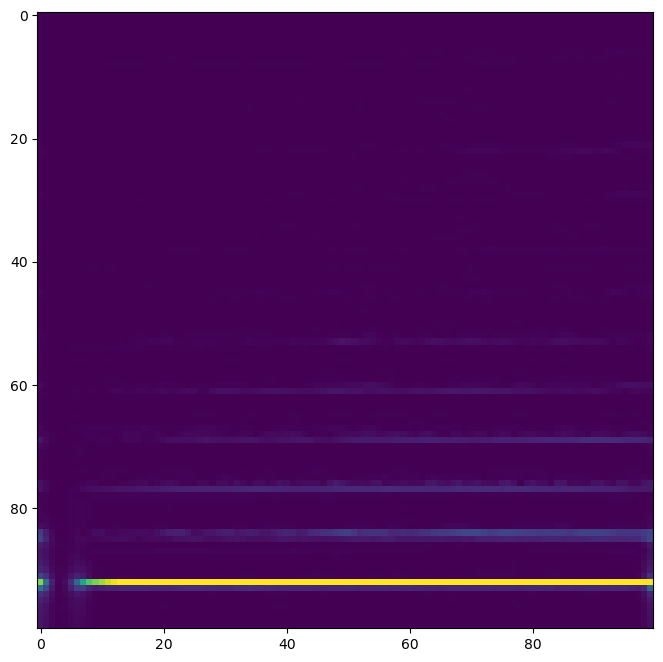

In [166]:
plt.figure(figsize=(12,8))
plt.imshow(np.abs(c_flute[:M//2,:]), vmin=0, vmax=1)
plt.show()

In [163]:
c_vec_drums = Ana @ drums
c_drums = np.flipud(np.reshape(c_vec_drums,(N,M)).T)

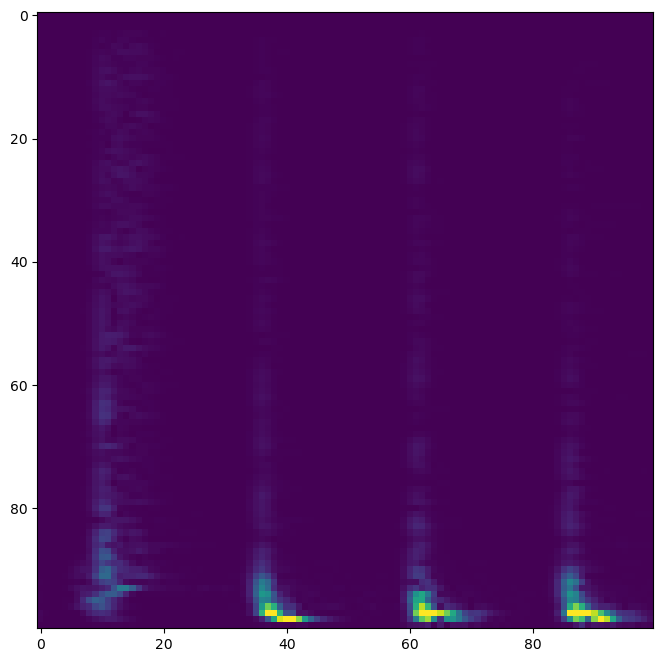

In [165]:
plt.figure(figsize=(12,8))
plt.imshow(np.abs(c_drums[:M//2,:]), vmin=0, vmax=2)
plt.show()